In [1]:
import numpy as np
import tensorflow as tf
import random

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath(".."))

from src.evaluations import compute_metrics, save_report


SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


In [2]:
X_train = np.load("../data/X_train.npy")
X_test  = np.load("../data/X_test.npy")
y_train = np.load("../data/y_train.npy")
y_test  = np.load("../data/y_test.npy")

X_train.shape, X_test.shape


((398, 30), (171, 30))

In [3]:
X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_seq  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train_seq.shape


(398, 30, 1)

In [4]:
BATCH_SIZE = 128
EPOCHS = 3000
GRU_CELL_SIZE = 128
DROPOUT_RATE = 0.5
LEARNING_RATE = 1e-3
SVM_C = 5


In [5]:
inputs = layers.Input(shape=(30, 1))
x = layers.GRU(GRU_CELL_SIZE)(inputs)
x = layers.Dropout(DROPOUT_RATE)(x)
embeddings = layers.Dense(128, activation="relu", name="embedding")(x)

output = layers.Dense(1, activation="sigmoid")(embeddings)

gru_model = models.Model(inputs, output)
gru_model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

gru_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,945 (261.50 KB)

 Trainable params: 66,945 (261.50 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = gru_model.fit(
    X_train_seq, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_seq, y_test),
    verbose=0
)

print("GRU training finished")


GRU training finished


In [7]:
encoder = models.Model(
    inputs=gru_model.input,
    outputs=gru_model.get_layer("embedding").output
)

X_train_emb = encoder.predict(X_train_seq, batch_size=BATCH_SIZE)
X_test_emb  = encoder.predict(X_test_seq, batch_size=BATCH_SIZE)

X_train_emb.shape


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


(398, 128)

In [8]:
svm = SVC(C=SVM_C, kernel="rbf", random_state=SEED)
svm.fit(X_train_emb, y_train)

y_pred = svm.predict(X_test_emb)


In [9]:
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

accuracy = accuracy_score(y_test, y_pred)
TPR = TP / (TP + FN)
TNR = TN / (TN + FP)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

print("GRU-SVM Results")
print("Accuracy:", accuracy)
print("TPR:", TPR)
print("TNR:", TNR)
print("FPR:", FPR)
print("FNR:", FNR)
print("Confusion Matrix:\n", cm)


GRU-SVM Results
Accuracy: 0.9473684210526315
TPR: 0.9626168224299065
TNR: 0.921875
FPR: 0.078125
FNR: 0.037383177570093455
Confusion Matrix:
 [[ 59   5]
 [  4 103]]


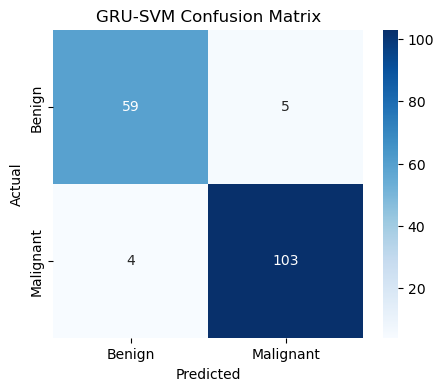

In [10]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Malignant"],
            yticklabels=["Benign","Malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("GRU-SVM Confusion Matrix")
plt.show()


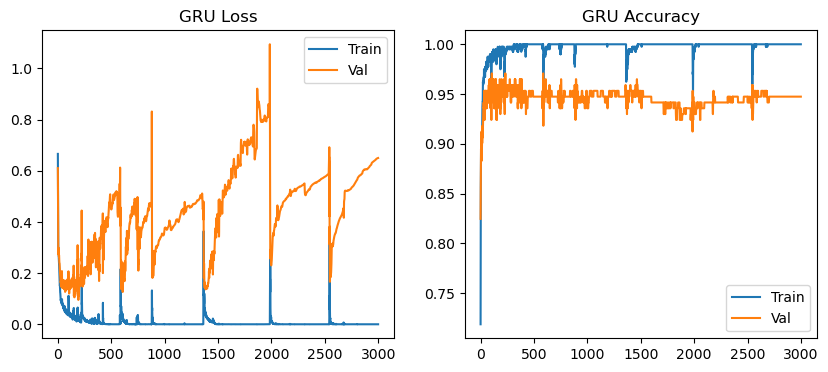

In [11]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("GRU Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("GRU Accuracy")
plt.legend()

plt.show()


In [12]:
# GRU model
gru_model.save("../saved_models/gru_encoder.keras", include_optimizer=False)

# SVM part
import joblib
joblib.dump(svm, "../saved_models/gru_svm.pkl")

print("GRU + SVM saved")


GRU + SVM saved


In [13]:
metrics = compute_metrics(y_test, y_pred)

save_report(
    model_name="GRU_SVM",
    metrics=metrics,
    hyperparams={
        "batch_size": 128,
        "cell_size": 128,
        "dropout": 0.5,
        "learning_rate": 1e-3,
        "svm_C": 5,
        "norm": "L2"
    },
    epochs=3000,
    datapoints=128 * 3000
)


[OK] Report saved to: C:\Users\alaas\Project_folder_BREAST_CANCER\reports\GRU_SVM_report.json


In [23]:
np.save("../reports/GRU_SVM_history.npy", history.history)

In [24]:
X_test_emb = encoder.predict(X_test_seq, batch_size=128)
y_pred_prob = svm.predict_proba(X_test_emb)[:, 1]
np.save("../reports/GRU_SVM_y_prob.npy", y_pred_prob)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
